In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'published_in': 'Cement and Concrete Res

In [2]:
# normalize data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# y_scaler = StandardScaler()
# y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.3, random_state=42)

X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.15, random_state=42)




In [3]:
import torch 

if torch.backends.mps.is_available():
    device = "mps"
    
elif torch.cuda.is_available():
    device = "cuda"

else:
    device = "cpu"    

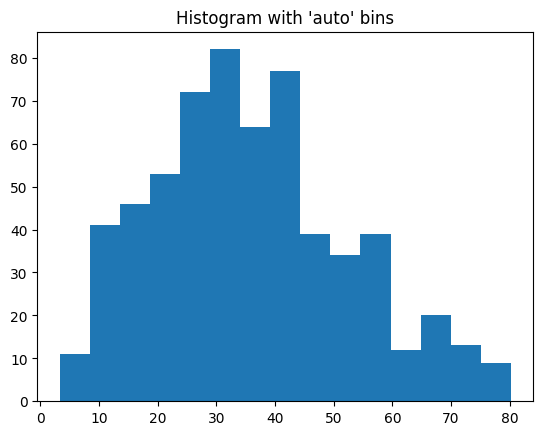

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')

global MAX_VAL 
global MIN_VAL

MIN_VAL = 0
MAX_VAL = 85

y_train = y_train.flatten()
y_test = y_test.flatten()
hist, bin_edges, _ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
# hist, bin_edges, _ = plt.hist(y_train, bins=30)  # arguments are passed to np.histogram
class_digits = np.digitize(y_train, bin_edges) # Get the class of each point using histogram bins

no_of_classes = bin_edges.shape[0]+1
one_hots = np.zeros((y_train.size, no_of_classes))
one_hots[np.arange(y_train.size), class_digits] = 1

test_hots = np.zeros((y_test.size, no_of_classes))
test_hots[np.arange(y_test.size), np.digitize(y_test, bin_edges)] = 1

plt.title("Histogram with 'auto' bins")
plt.show()


# Avoid copy data, just refer
train_x_tr = torch.from_numpy(X_train.reshape([-1,8])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_scalar = torch.from_numpy(y_train.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(one_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()

test_x_tr = torch.from_numpy(X_test.reshape([-1,8])).float()#torch.from_numpy(data['x'].values[1000:]).unsqueeze(dim=1).float()
test_y_scalar = torch.from_numpy(y_test.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()
test_y_tr = torch.from_numpy(test_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()



calib_x_tr = torch.from_numpy(X_calib.reshape([-1,8])).float()#torch.from_numpy(data['x'].values[1000:]).unsqueeze(dim=1).float()
calib_y_scalar = torch.from_numpy(y_calib.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()
calib_y_tr = torch.from_numpy(np.zeros((y_calib.size, no_of_classes))).float()#torch.from_numpy(data['y'].values[1000:]).unsqueeze(dim=1).float()


intervals = np.array(list(zip([MIN_VAL, *bin_edges], [*bin_edges, MAX_VAL])))


In [5]:
class QClassifier(torch.nn.Module):
    def __init__(self, in_size=1, no_of_classes=55):
        super(QClassifier,self).__init__()
        self.in_size = in_size
        self.out_size = no_of_classes

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            # torch.nn.Dropout(p=0.9),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [6]:
# def calculate_tau()



In [7]:
train_x_tr = train_x_tr.to(device)
train_y_tr = train_y_tr.to(device)

model = QClassifier(in_size=8, no_of_classes=no_of_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [8]:
train_x_tr.shape

torch.Size([612, 8])

In [9]:

losses = []
for step in range(4000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x_tr)
    loss = criterion(logits, train_y_tr)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 1000 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=2.832
epoch 1000 loss=0.7873
epoch 2000 loss=0.4131


KeyboardInterrupt: 

In [26]:

# model.eval()
# y_pred = model(calib_x_tr.to(device))
# probs = y_pred.softmax(dim=1)


# y_target = calib_y_tr
# sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
# sorted_cdf = sorted_pdf.cumsum(dim=1)

# error_rate = 0.10 # 10% error rate

# confidence_level = 1 - error_rate  # This computes to 0.90
# # Finding tau using conformal prediction, ensuring correct class inclusion
# taus = []
# for i, (cdf, indices) in enumerate(zip(sorted_cdf, sorted_indices)):
#     true_class_index = torch.where(indices == y_target[i])[0][0]  # Find index of the true class
#     print(f"True class index: {true_class_index}")
    
    
    
# #     tau = cdf[true_class_index]
# #     taus.append(tau)
    
# # qhat = np.quantile(taus, confidence_level)
    


True class index: 15
True class index: 12
True class index: 13
True class index: 11
True class index: 14
True class index: 11
True class index: 16
True class index: 14
True class index: 16
True class index: 13
True class index: 9
True class index: 16
True class index: 12
True class index: 13
True class index: 11
True class index: 16
True class index: 13
True class index: 15
True class index: 14
True class index: 11
True class index: 10
True class index: 14
True class index: 9
True class index: 14
True class index: 11
True class index: 9
True class index: 10
True class index: 16
True class index: 14
True class index: 13
True class index: 14
True class index: 14
True class index: 10
True class index: 14
True class index: 15
True class index: 12
True class index: 12
True class index: 13
True class index: 16
True class index: 16
True class index: 16
True class index: 13
True class index: 13
True class index: 14
True class index: 11
True class index: 13
True class index: 9
True class index:

In [25]:
qhat

1.0000000238418578

tensor(1.)

In [40]:

import matplotlib.pyplot as plt 
import numpy as np

def calculate_metrics_plot(model, X, y, bin_edges, intervals,tau=0.5,gaussian_filter=False):
        model.eval()
        y_pred = model(X.to(device))
        probs = y_pred.softmax(dim=1)
        if gaussian_filter:
                from scipy.ndimage import gaussian_filter1d
                probs = gaussian_filter1d(probs.detach().cpu().numpy(), sigma=1, axis=1)
                probs = torch.from_numpy(probs).float()
        
        sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
        sorted_cdf = sorted_pdf.cumsum(dim=1)
        first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)

        plt.plot(y,y, color='blue',alpha=0.5)
        gt = np.digitize(y, bin_edges)

        correctness_list = []
        quantile_length_list = []
        for i in range(sorted_indices.shape[0]):
                # print(sorted_indices[i][:first_nth_indices[i]+1])
                prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
                correctness_list.append(gt[i][0] in prediction_set)
                        
                element_length = 0
                for j in range(len(prediction_set)):
                        bar_min, bar_max  = intervals[prediction_set[j]]
                        element_length += bar_max - bar_min
                        plt.bar(y[i], height= bar_max-bar_min, bottom=bar_min, width= 0.5 ,color='red', alpha=0.2)
                quantile_length_list.append(element_length)

        # PINAW
        true_count = np.sum(correctness_list)
        pinaw = np.mean(quantile_length_list) / (MAX_VAL - MIN_VAL)
        print(f'PINAW: {pinaw}')
        picp = true_count / sorted_indices.shape[0]
        ace = picp - tau
        print(f'PICP: {picp}, ACE: {ace}')

PINAW: 0.11114058233230469
PICP: 0.9958391123439667, ACE: 0.4958391123439667


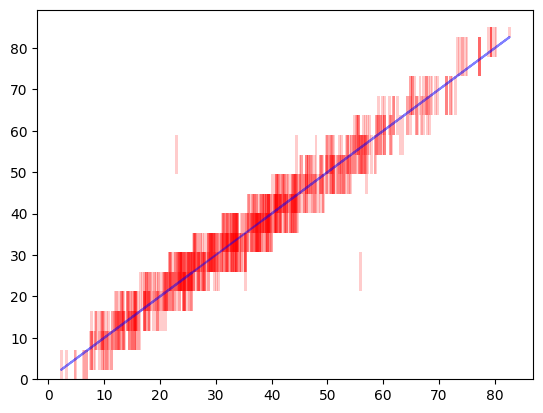

In [53]:
calculate_metrics_plot(model, train_x_tr, train_y_scalar, bin_edges, intervals, tau=0.5,gaussian_filter=True)

PINAW: 0.06912757975834537
PICP: 0.540453074433657, ACE: -0.35954692556634305


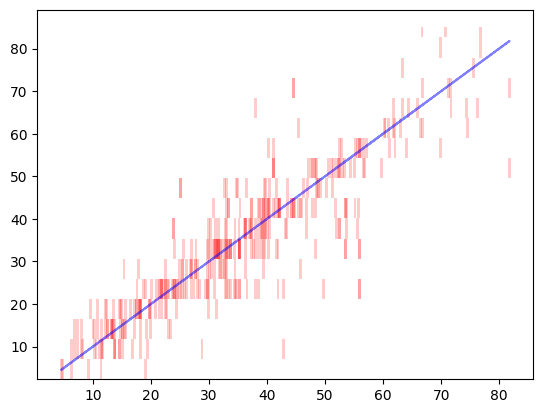

In [56]:
calculate_metrics_plot(model, test_x_tr, test_y_scalar, bin_edges, intervals, tau=0.9,gaussian_filter=False)